# Bands Structure
For the source code, see [bands](https://workgraph-collections.readthedocs.io/en/latest/qe/module.html#workgraph_collections.ase.espresso.bands.bands_workgraph).


## Example: Silicon band structure
### Prepare the inputs and visualize the WorkGraph



In [2]:
from copy import deepcopy
from aiida import load_profile
from aiida.orm import Dict, KpointsData, StructureData, load_code
from ase.build import bulk
from workgraph_collections.qe.bands import BandsWorkgraph

load_profile()

atoms = bulk('Si')
structure_si = StructureData(ase=atoms)

pw_code = load_code('pw-7.4@localhost')
scf_paras = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'ecutwfc': 30,
        'ecutrho': 240,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.1,
    },
}
relax_paras = deepcopy(scf_paras)
relax_paras['CONTROL']['calculation'] = 'vc-relax'
bands_paras = deepcopy(scf_paras)
bands_paras['CONTROL']['calculation'] = 'bands'

kpoints = KpointsData()
kpoints.set_kpoints_mesh([3, 3, 3])
#
metadata = {
    'options': {
        'resources': {
            'num_machines': 1,
            'num_mpiprocs_per_machine': 4,
        },
    }
}

bands_inputs = {
    'relax': {
        'base': {
            'pw': {
                'parameters': Dict(relax_paras),
                'metadata': metadata,
            },
            'kpoints': kpoints,
        },
    },
    'scf': {
        'pw': {
            'parameters': Dict(scf_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'bands': {
        'pw': {
            'parameters': Dict(bands_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
}

wg = BandsWorkgraph.build(
    structure=structure_si,
    code=pw_code,
    inputs=bands_inputs,
    pseudo_family='SSSP/1.3/PBEsol/efficiency',
    run_relax=True,
    bands_kpoints_distance=0.1,
)
wg.to_html()

## Run the WorkGraph

In [3]:
from workgraph_collections.qe import PwBaseTask, PwRelaxTask, SeekpathTask

PwBaseTask.inputs.pw.structure

In [4]:
wg.run()

10/08/2025 11:07:57 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201657|WorkGraphEngine|continue_workgraph]: tasks ready to run: PwRelaxWorkChain
10/08/2025 11:07:58 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201657|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 201663
10/08/2025 11:08:00 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201663|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<201666>
10/08/2025 11:08:01 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201666|PwBaseWorkChain|run_process]: launching PwCalculation<201669> iteration #1
10/08/2025 11:08:09 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201666|PwBaseWorkChain|results]: work chain completed after 1 iterations
10/08/2025 11:08:09 AM <2492378> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [201

{'remote_folder': <RemoteData: uuid: 0ded22e7-56c1-42a3-97ff-4040d6577c73 (pk: 201716)>,
 'retrieved': <FolderData: uuid: 93ecb97c-b2f4-4c5d-8890-13ede4c62446 (pk: 201717)>,
 'output_parameters': <Dict: uuid: 90060700-b234-4357-a122-15f6e37195fd (pk: 201720)>,
 'output_trajectory': <TrajectoryData: uuid: e37b745f-849f-4f80-84e4-53311c3bc453 (pk: 201719)>,
 'output_band': <BandsData: uuid: 8cc1fcf3-1798-4570-8f19-a6c1b734e3b5 (pk: 201718)>}

## Plot the band structure

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Dispersion (eV)'>)

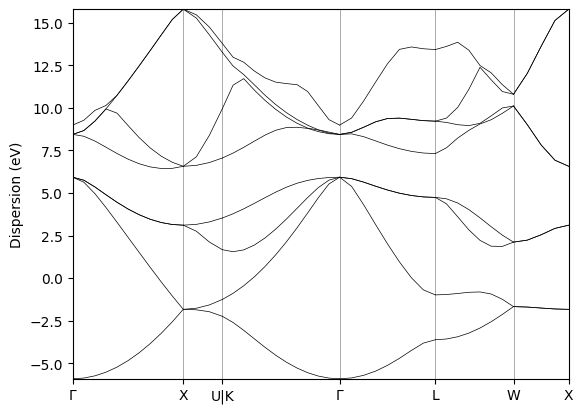

In [5]:
from workgraph_collections.qe.utils import plot_bandstructure
    
bands = wg.outputs.output_band.value
plot_bandstructure(bands)